In [ ]:
!sudo apt install libusb-dev make
!pip install chipwhisperer

In [ ]:
HammingWeightFn = lambda x: bin(x).count('1')

# Precompute Hamming Weight
HammingWeight = [ HammingWeightFn(n) for n in range (0x00, 0xff + 1) ]

# Rijndael Substitution box
SBox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def hypothetical_power_usage(subkey, plain_text_char):

    # Use the Hamming Weight power usage model
    return HammingWeight[

        # Do a SBox look up of the XOR-ed value
        #
        # Since the Hamming Weight of the SBox value will
        # persist for longer in memory this will make finding the
        # pattern easier. It is also still before the Row Shifting
        # so it doesn't cause trouble.
        SBox [

            # The initial round key XOR-ed with the plain text
            subkey ^ plain_text_char
        ]
    ]


In [ ]:
import numpy as np

traces = np.load('power_traces.npy')
textins = np.load('plaintexts.npy')

num_traces = np.shape(traces)[0]
num_points = np.shape(traces)[1]



In [ ]:
def covariance(X, Y):
    if len(X) != len(Y):
        print("Lengths are unequal, quiting...")
        quit()

    n = len(X)
    mean_x = np.mean(X, dtype=np.float64)
    mean_y = np.mean(Y, dtype=np.float64)

    return np.sum((X - mean_x) * (Y - mean_y)) / n

def standard_deviation(X):
    n = len(X)
    mean_x = np.mean(X, dtype=np.float64)

    return np.sqrt( np.sum( np.power( (X - mean_x), 2 ) ) / n )

def pearson_correlation_coefficient(X, Y):
    cov = covariance(X, Y)
    sd_x = standard_deviation(X)
    sd_y = standard_deviation(Y)

    return cov / ( sd_x * sd_y )


In [ ]:
from tqdm import trange

def calculate_correlation_coefficients(subkey, subkey_index):
    # Declare a numpy for the hypothetical power usage
    hypothetical_power = np.zeros(num_traces)

    for trace_index in range(0, num_traces):
        hypothetical_power[trace_index] = hypothetical_power_usage(
            subkey,
            textins[trace_index][subkey_index]
        )

    # We are going to the determine correlations between each trace point
    # and the hypothetical power usage. This will save all those coefficients
    point_correlation = np.zeros(num_points)

    # Loop through all points and determine their correlation coefficients
    for point_index in range(0, num_points):
        point_correlation[point_index] = pearson_correlation_coefficient(
            hypothetical_power,

            # Look at the individual traces points for every trace
            traces[:, point_index]
        )

    return point_correlation

# Save all correlation coefficients
max_correlation_coefficients = np.zeros(256)

# Loop through values this subkey
for subkey in trange(0xff + 1, desc="Attack Subkey"):
    max_correlation_coefficients[subkey] = max(abs(
        calculate_correlation_coefficients(subkey, 0)
    ))


Attack Subkey: 100%|██████████| 256/256 [00:58<00:00,  4.35it/s]


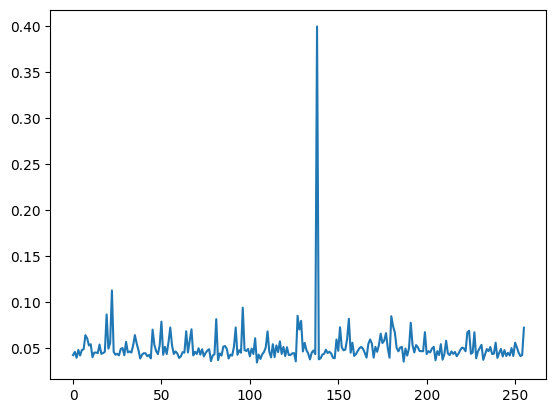

In [ ]:
import matplotlib.pyplot as plt

plt.plot(max_correlation_coefficients)
plt.show()


In [ ]:
# Select the element with the highest correlation
best_guess = np.argmax(max_correlation_coefficients)

# Print both the hex value and the ASCII character
print("Best guess: {:02x} or '{}'".format(best_guess, chr(best_guess)))


Best guess: 8a or ''


In [ ]:
# Looping through all possible bytes
########################################
# Save all correlation coefficients
max_correlation_coefficients = np.zeros(256)

# Loop through values this subkey
for subkey in trange(0xff + 1, desc="Attack Subkey"):
    max_correlation_coefficients[subkey] = max(abs(
        calculate_correlation_coefficients(subkey, 0)
    ))
########################################

# Printing the best guess
########################################
# Select the element with the highest correlation
best_guess = np.argmax(max_correlation_coefficients)

# Print both the hex value and the ASCII character
print("Best guess: {:02x} or '{}'".format(best_guess, chr(best_guess)))
########################################


Attack Subkey: 100%|██████████| 256/256 [00:59<00:00,  4.27it/s]

Best guess: 8a or ''


In [ ]:
# Looping through all subkeys
########################################
# The eventual key guess
best_guess = np.zeros(16)

# Loop through all possible subkeys
for subkey_index in trange(16, desc="Subkey Index"):
    # Save all correlation coefficients
    max_correlation_coefficients = np.zeros(256)

    # Loop through values this subkey
    for subkey in range(0x00, 0xff + 1):
        max_correlation_coefficients[subkey] = max(abs(
            calculate_correlation_coefficients(subkey, subkey_index)
        ))

    # Save the best guess
    best_guess[subkey_index] = np.argmax(max_correlation_coefficients)
########################################

# Printing the best guess
########################################
print("Best guess:")
for b in best_guess: print("{:02x} ".format(int(b)), end="")
print("")
for b in best_guess: print("{}".format(chr(int(b))), end="")
print("")
########################################


Subkey Index: 100%|██████████| 16/16 [16:09<00:00, 60.57s/it]

Best guess:
8a 86 d9 ae 01 45 6c e4 c8 15 2a 61 87 4a 93 a9 
Ù®EläÈ*aJ©
